<div style="border:1px solid black; padding:10px 10px;">
    <strong>CIVIL-321 "Modélisation Numérique des Solides et Structures"</strong><br/><br/>
    <span style="text-decoration:underline;font-weight:bold;">Comment utiliser ce Jupyter Notebook?
    </span><br/><br/>
    Ce <strong>Notebook</strong> est constitué de cellules de texte et de cellule de code. Les cellules de codes 
    doivent être  <strong>executées</strong> pour voir le résultat du programme. Certaines cellules doivent être 
    remplies par vos soins. Pour exécuter une cellule, cliquez dessus simplement et ensuite cliquez sur le bouton 
    "play" (<span style="font: bold 12px/30px Arial, serif;">&#9658;</span>) dans la barre de menu au dessus du
    notebook. Vous pouvez aussi taper la combinaison de touches <code>shift + enter</code>. Il est important 
    d'éxécuter les cellules de code en respectant leur ordre d'arrivée dans le notebook.
</div>

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from plot import *

<div style="border:1px solid black; padding:10px 10px;">
    <strong>Template pour le projet</strong><br/><br/>
    <span style="text-decoration:underline;font-weight:bold;">Template pour le projet
    </span><br/><br/>
    Ce <strong>Notebook</strong> est divisé en deux parties:
    
    - Dans la première partie est rassemblée les fonctions de base pour construire les matrices de rigidité et masse. Selon l'énoncé de votre projet, il faudra les adapter (changer les propriétés des matériaux par exemple).
    
    - Dans la seconde partie se trouve un exemple simple de résolution en dynamique. Vous pouvez ensuite l'adapter à votre géométrie, vos conditions de bord et conditions initiales.
</div>

### Fonctions pour construire la matrice de rigidité

La matrice D représente la loi constituve faisant le lien entre les déformations et les contraintes.

In [2]:
def calculerD(contraintes_planes=True):
    
    E = 210e3 # 210GPa = 210e9 N/m^2 = 210e3 N/mm^2
    nu = 0.3    

    # On fait des contraintes planes par défaut
    if contraintes_planes:
        D = (E/(1-nu**2))* np.array(
            [[1,  nu, 0],
             [nu, 1,  0],
             [0,  0,  (1-nu)/2]])
    else:
        raise RuntimeError('Déformations planes à implémenter!')
    return D

La matrice C relie les déplacements en coordonnées réeles aux gradients en coordonnées naturelles

In [3]:
def calculerC():
    N1s, N1t = [-1, -1]
    N2s, N2t = [1, 0]
    N3s, N3t = [0, 1]
    C = np.array([
        [N1s, 0, N2s, 0, N3s, 0],
        [N1t, 0, N2t, 0, N3t, 0],
        [0, N1s, 0, N2s, 0, N3s],
        [0, N1t, 0, N2t, 0, N3t]])
    return C

La matrice B fait le lien entre les déplacements aux noeuds et les déformations dans l'élément. La matrice J est la matrice jacobienne du changement de coordonnées. 

In [4]:
def calculerBetJ(x, noeuds):
    C = calculerC()

    grads = C@noeuds.ravel()
    J = np.array([[grads[0], grads[2]],
                  [grads[1], grads[3]]])
    
    
    # Définition de A
    A = np.array([
        [1, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 1, 1, 0]
    ])

    # Définition de la matrice contenant les Jacobiennes
    Jblock = np.zeros((4, 4))
    Jblock[:2, :2] = J
    Jblock[2:, 2:] = J
    
    Mat_J = np.linalg.inv(Jblock)
    B = A@Mat_J@C
    return B, J

Calcul de la matrice de rigidité d'un unique élément

In [5]:
def calculerMatriceRigiditeLocale(connectivite_element, coordonnees):
    
    quads = [[1/3, 1/3]]
    weights = [1/2]
    
    noeuds = coordonnees[connectivite_element.ravel(), :] # les noeuds de l'élément traité
    K_local = np.zeros((6, 6)) # 6x6 for T3 only
    
    for x_q, w_q in zip(quads, weights):
        B, J = calculerBetJ(x_q, noeuds)  # calcule B et J sur le point de quadrature x_q
        detJ = np.linalg.det(J)           # calcule det(J) pour l'intégration
        D = calculerD()                   # calcule la loi de constitution D
           
        # somme la quadrature avec le poid w_q
        K_local = K_local + w_q * B.T@D@B * detJ
        
    # l'épaisseur
    t = 10. # mm
    
    return t*K_local

Permet de relier les degrés de liberté à leur position (ligne et colonne associées) dans les matrices K et M

In [6]:
def calculerNumerosEquations(connectivite):

    n_elem  = connectivite.shape[0]
    n_nodes_per_elem = connectivite.shape[1]
    numEq = np.zeros((n_elem, 2*n_nodes_per_elem), dtype=int)
    for e in range(n_elem):
        for i in range(n_nodes_per_elem):
            numEq[e, 2*i]   = 2*connectivite[e, i];
            numEq[e, 2*i+1] = 2*connectivite[e, i]+1;
    return numEq

Assemble les matrices locales en une matrice globale

In [7]:
def assemblerMatriceRigidite(connectivite, coordonnees):

    n_elem  = connectivite.shape[0]
    n_nodes = coordonnees.shape[0]
    numEq = calculerNumerosEquations(connectivite)

    K = np.zeros((n_nodes*2, n_nodes*2))
    for e in range(n_elem):
        # On récupère les degrés de liberté de l'élément e
        ddl = numEq[e, :]
        # On récupère les noeuds de l'élément e
        connectivite_element = connectivite[e, :]
        # On calcule la matrice de rigidite locale de l'élément e
        K_locale = calculerMatriceRigiditeLocale(connectivite_element, coordonnees)
        # On assemble
        for i, gi in enumerate(ddl):
            for j, gj in enumerate(ddl):
                K[gi, gj] += K_locale[i, j]
    return K

## Fonction pour contruire la matrice de masse

Permet d'interpoler une valeur à la position X dans l'élément (en coordonnées naturelles) à partir des valeurs aux noeuds

In [8]:
def calculerN(X, noeuds):
    s = X[0]
    t = X[1]
    N1 = 1-s-t  
    N2 = s       
    N3 = t
    return np.array([[N1, 0, N2, 0, N3, 0],
                     [0, N1, 0, N2, 0, N3]])

Calcul de la matrice de masse d'un unique élément

In [9]:
def calculerMatriceMasseLocale(connectivite_element, coordonnees):
    
    rho = 9e-3 # 9e3 Kg/m^3 = 9e-3 Kg/mm^2
    quads = [[1/6, 1/6], 
             [2/3, 1/6],
             [1/6, 2/3]]
    weights = [1/6, 1/6, 1/6]
    
    noeuds = coordonnees[connectivite_element.ravel(), :] # les noeuds de l'élément traité
    M_local = np.zeros((6, 6)) # 6x6 for T3 only
    
    for x_q, w_q in zip(quads, weights):
        N = calculerN(x_q, noeuds)        # calcule B et J sur le point de quadrature x_q
        B, J = calculerBetJ(x_q, noeuds)  # calcule B et J sur le point de quadrature x_q
        detJ = np.linalg.det(J)           # calcule det(J) pour l'intégration
           
        # somme la quadrature avec le poid w_q
        M_local = M_local + w_q * rho*N.T@N * detJ
        
    t = 10. # mm
    return t*M_local

Assemble les matrices locales en une matrice globale

In [10]:
def assemblerMatriceMasse(connectivite, coordonnees):

    n_elem  = connectivite.shape[0]
    n_nodes = coordonnees.shape[0]
    numEq = calculerNumerosEquations(connectivite)

    M = np.zeros((n_nodes*2, n_nodes*2))
    for e in range(n_elem):
        # On récupère les degrés de liberté de l'élément e
        ddl = numEq[e, :]
        # On récupère les noeuds de l'élément e
        connectivite_element = connectivite[e, :]
        # On calcule la matrice de rigidite locale de l'élément e
        M_locale = calculerMatriceMasseLocale(connectivite_element, coordonnees)
        # On assemble
        for i, gi in enumerate(ddl):
            for j, gj in enumerate(ddl):
                M[gi, gj] += M_locale[i, j]
    return M

# Exemple de résolution de problème en dynamique

## Définition du maillage

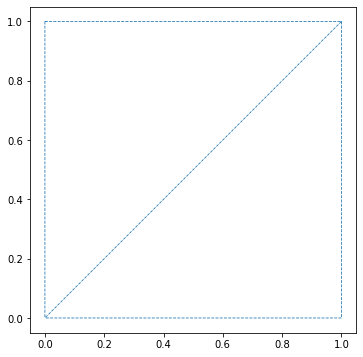

In [11]:
points = np.array([[0.0,0],
                   [1,0],
                   [1,1],
                   [0,1]])

conn = np.array([[0,1,2],
                 [2,3,0]])

plotMesh(points, conn)

## Construction des matrices

In [12]:
K = assemblerMatriceRigidite(conn, points)
M = assemblerMatriceMasse(conn, points)

# La matrice lumped rassemble la masse sur les termes diagonaux. Dans un schéma explicite d'intégration
# dans le temps, elle permet d'éviter la résolution d'un système d'équations linéaires
Mlumped_vector = np.sum(M,axis=1)
Mlumped = np.diag(Mlumped_vector)


## Conditions de bord

In [13]:
blocked = np.zeros_like(points).astype('bool')
blocked[0,:] = True # Noeud en bas à gauche, bloqué selon x et y
blocked[1,1] = True # Noeud en bas à droite, bloqué selon y

libres = np.logical_not(blocked)

## Conditions initiales

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


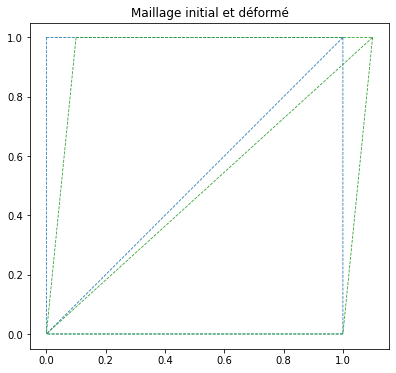

In [14]:
# Initialisation des vecteurs de déplacements, vitesses, acc
V = np.zeros_like(points)  # velocities
A = np.zeros_like(points)  # accelerations
U = np.zeros_like(points)      # displacements
F = np.zeros_like(points)      # external forces


# Un déplacement horizontal initial est appliqué en haut
U[2:,0]+=0.1
  
plt.figure()
plotMesh(points, conn)
plotMesh(points+U, conn)
plt.title('Maillage initial et déformé')
plt.show()


/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


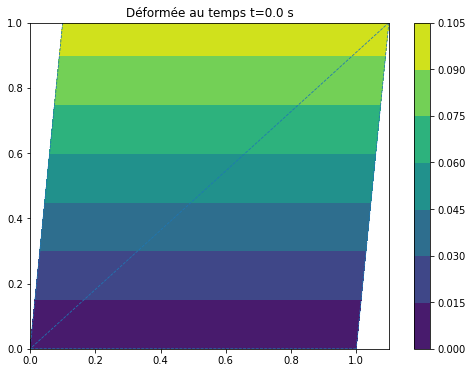

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


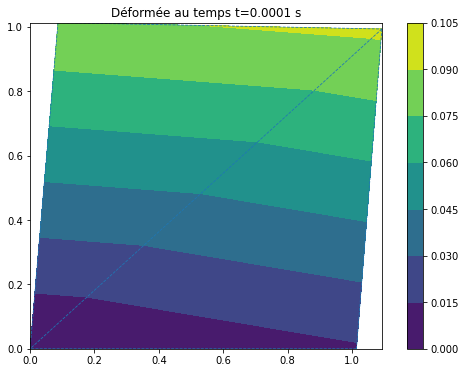

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


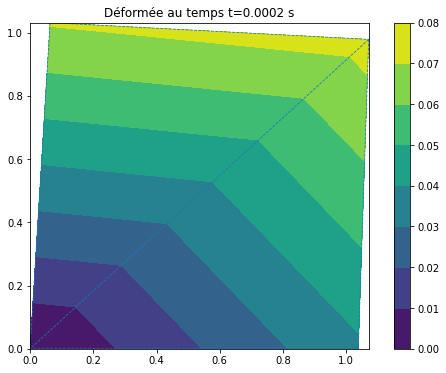

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


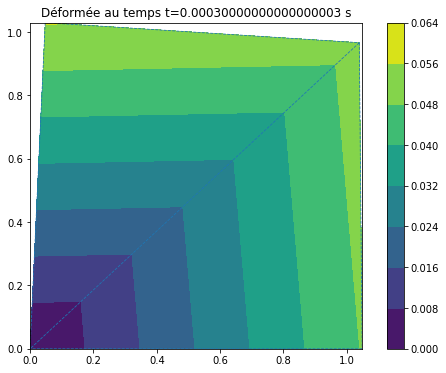

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


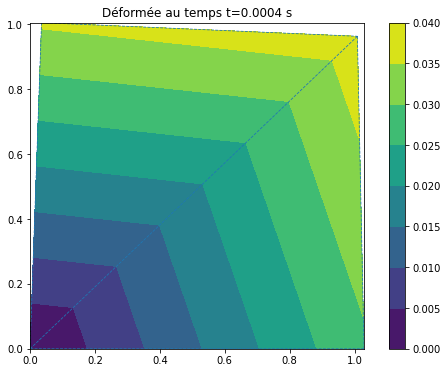

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


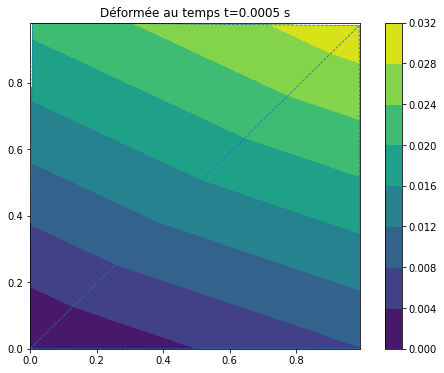

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


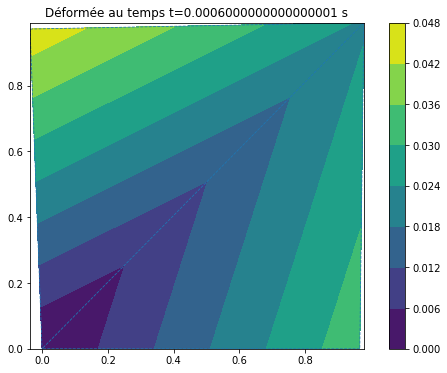

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


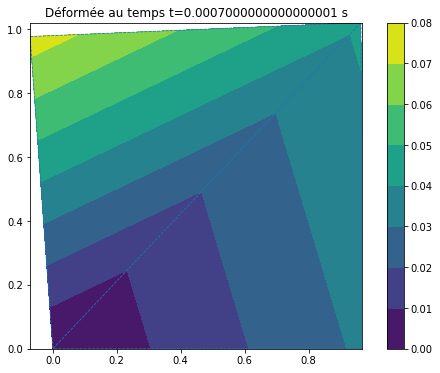

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


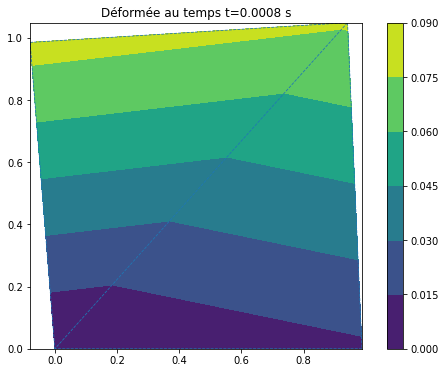

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


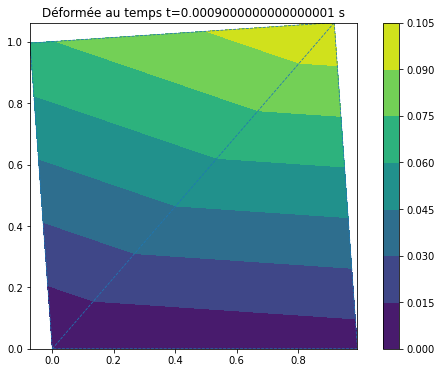

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


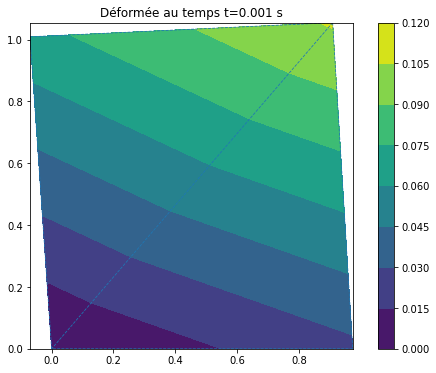

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


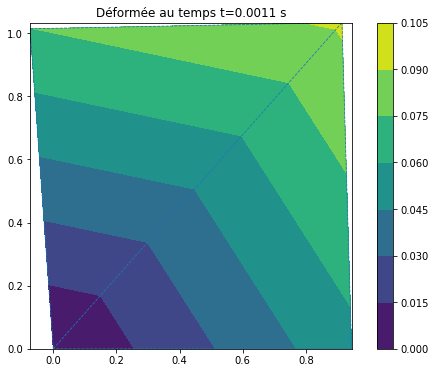

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


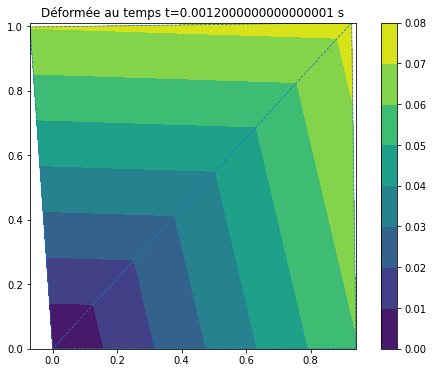

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


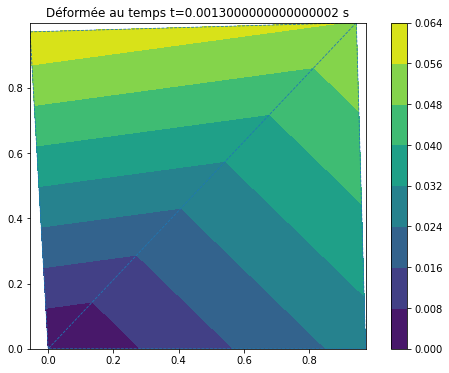

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


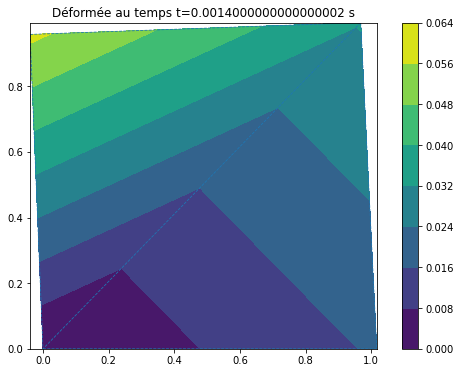

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


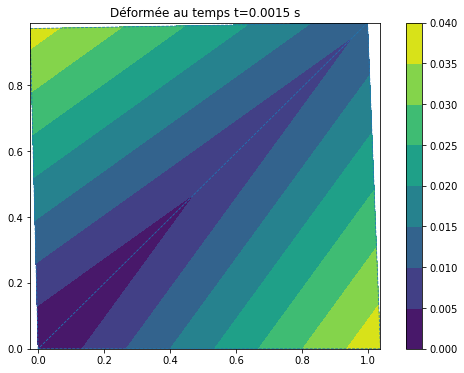

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


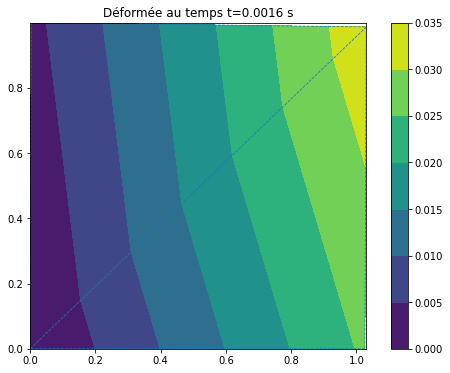

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


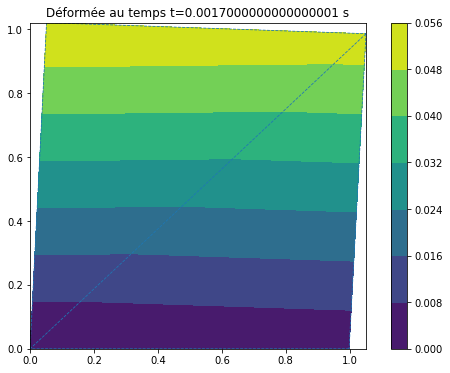

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


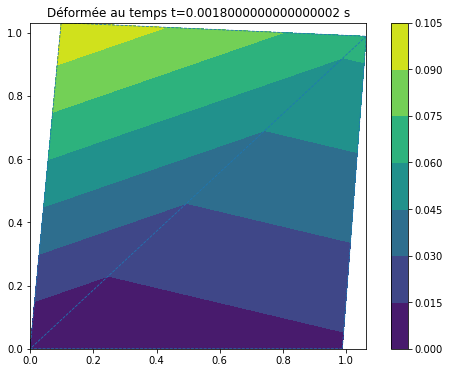

/home/wattel/WORK/TA/MNSS22/mnss-notebooks-teachers/07_Projet/plot.py:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal')


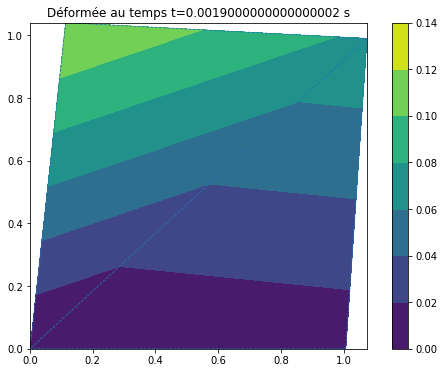

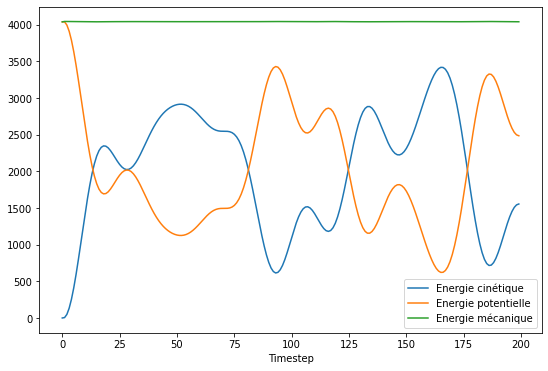

In [15]:
# Pas de temps
dt = 1e-5

# Nombre d'itérations
nstep = 200

# Sous forme de vecteurs pour faciliter l'algèbre avec les matrices
U = U.reshape((-1,1))
V = V.reshape((-1,1))
A = A.reshape((-1,1))
F = F.reshape((-1,1))
blocked = blocked.reshape((-1,1))

# Pour stocker les énergies à chaque pas de temps
Ecin_list = []
Epot_list = []
Emec_list = []


for s in range(0, nstep):
    
    
    # Calcul et stockage des énergies
    Ecin = 0.5*V.T@Mlumped@V
    Epot = 0.5*U.T@K@U
    Emec = Epot+Ecin
    
    Ecin_list.append(Ecin[0,0])
    Epot_list.append(Epot[0,0])
    Emec_list.append(Emec[0,0])
    

    # Schéma d'intégration explicite
    # ATTENTION : Fonctionne uniquement pour matrice de masse lumped
    
    V_star = V + dt/2*A
    U[:] = U + dt*V_star
    # enforce displacement boundary conditions by changing U
    U[blocked] = 0
    # enforce tractions by changing F
    F[:] = 0

    A[:] = (-K@U+F)/Mlumped_vector.reshape((-1,1))
    V[:] = V_star + dt/2*A
    
    # enforce consistant boundary conditions by changing V
    V[blocked] = 0 # time derivative == velocity
    
    # Plot de la déformée tous les 10 pas de temps
    if s%10 == 0:
        plt.figure()
        plt.title("Déformée au temps t={} s".format(s*dt))
        plotMesh(points+U.reshape((-1,2)), conn, nodal_field=U)
        plt.show()
    
    
    
    
U = U.reshape((-1,2))
V = V.reshape((-1,2))
A = A.reshape((-1,2))
F = F.reshape((-1,2))
blocked = blocked.reshape((-1,2))

# Vérification de la conservation de l'énergie mécanique
plt.figure()
plt.plot(Ecin_list, label = "Energie cinétique")
plt.plot(Epot_list, label = "Energie potentielle")
plt.plot(Emec_list, label = "Energie mécanique")
plt.xlabel("Timestep")
plt.legend()
plt.show()